# Notebook

Objective: identifying skills keywords from job descritions with basic NLP techniques.

In [1]:
import collections
import json
import matplotlib.pyplot as plt
import nltk
import pandas as pd
from wordcloud import WordCloud

from selenium import webdriver
from bs4 import BeautifulSoup
import time
import string
import numpy as np
import seaborn as sns
from tqdm import tqdm

## Data extraction

In [2]:
def url_to_soup(url):
    """"
    Step 1: extract url's html into soup object.
    """
    driver = webdriver.Chrome()
    driver.get(url)

    time.sleep(3)
    html = driver.page_source
    soup = BeautifulSoup(html, "html.parser")
    driver.close()
    return soup

# Check.
#url = "https://www.linkedin.com/jobs/search?keywords=Senior%20Data%20Scientist&location=United%20States"
#soup = url_to_soup(url)

In [3]:
def soup_to_jobs(soup):
    """"
    Step 2: get all jobs specific url from the LinkedIn general search.
    """
    descriptions = soup.find_all("a", class_="base-card__full-link absolute top-0 right-0 bottom-0 left-0 p-0 z-[2]")

    list_job_href = [i.get('href') for i in descriptions]
    print(f"Jobs found: {len(list_job_href)}")
    
    return list_job_href

# Check.
#list_job_href = soup_to_jobs(soup)

In [4]:
def jobs_to_description(list_href):
    """
    Step 3: extract raw job description from job posting.
    """
    list_title = []
    list_description = []
    
    for href in list_href:
        soup = url_to_soup(href)
        list_title.append(soup.find('title').string)
        list_description.append(soup.find('div', class_='show-more-less-html__markup show-more-less-html__markup--clamp-after-5').get_text())

    df = pd.DataFrame({'title': list_title, 'href': list_href, 'description':list_description})
    return df

# Check
#df = jobs_to_description(list_job_href[:3])

In [5]:
# Creating single list of LinkedIn job's urls passing specific filters.
df_states = pd.read_html('https://www.jagranjosh.com/general-knowledge/list-of-states-in-usa-1663078166-1', header=0)[0]
df_states['State'] = df_states['State'].str.replace(' ', '%20')


list_url = []
for i in df_states['State']:
    # Name: Senior Data Scientist.
    list_url.append(f'https://www.linkedin.com/jobs/search?keywords=Senior%20Data%20Scientist&location={i}&position=1&pageNum=0')

    # Experience level: mid-senior level.
    list_url.append(f'https://www.linkedin.com/jobs/search?keywords=Senior%20Data%20Scientist&location={i}&f_TPR=&f_E=4&position=1&pageNum=0')

    # Name: Data Scientist III
    list_url.append(f'https://www.linkedin.com/jobs/search?keywords=Data%20Scientist%20III&location={i}&position=1&pageNum=0')

list_url[:5]

['https://www.linkedin.com/jobs/search?keywords=Senior%20Data%20Scientist&location=Alabama&position=1&pageNum=0',
 'https://www.linkedin.com/jobs/search?keywords=Senior%20Data%20Scientist&location=Alabama&f_TPR=&f_E=4&position=1&pageNum=0',
 'https://www.linkedin.com/jobs/search?keywords=Data%20Scientist%20III&location=Alabama&position=1&pageNum=0',
 'https://www.linkedin.com/jobs/search?keywords=Senior%20Data%20Scientist&location=Alaska&position=1&pageNum=0',
 'https://www.linkedin.com/jobs/search?keywords=Senior%20Data%20Scientist&location=Alaska&f_TPR=&f_E=4&position=1&pageNum=0']

In [6]:
def pipeline_extract(list_url):
    """
    Step 1 + 2 + 3: encapsulate all exctraction steps.
    """

    df_output = pd.DataFrame()
    for i in tqdm(list_url):
        try:
            soup = url_to_soup(i)
            list_job_href = soup_to_jobs(soup)
            df = jobs_to_description(list_job_href)
            df_output = pd.concat([df_output, df], axis=0).reset_index(drop=True)
        except:
            print(f"The url {i} did not return jobs.")

    df_output.drop_duplicates(inplace=True)
    return df_output

In [51]:
# Data extraction. Warning: the process takes at least 4 to 6 hours.
#df_raw = pipeline_extract(list_url)
#df_raw.to_csv('dataset.csv', index=False)

In [52]:
# Using data from previous extractions.
df_raw = pd.read_csv('dataset.csv')
df_raw.head(3)

,title,href,description
0,Recruiting from Scratch está contratando Senio...,https://www.linkedin.com/jobs/view/senior-data...,\nWho is Recruiting from Scratch: Recruiting f...
1,Recruiting from Scratch está contratando Senio...,https://www.linkedin.com/jobs/view/senior-data...,\nWho is Recruiting from Scratch: Recruiting f...
2,Intuitive Research and Technology Corporation ...,https://www.linkedin.com/jobs/view/entry-level...,\nINTUITIVE® is a nationally recognized Best P...


In [9]:
# Creating single list of LinkedIn job's urls passing specific filters.
df_states = pd.read_html('https://www.jagranjosh.com/general-knowledge/list-of-states-in-usa-1663078166-1', header=0)[0]
df_states['State'] = df_states['State'].str.replace(' ', '%20')


list_url = []
for i in df_states['State']:
    # Name: Senior Data Scientist.
    list_url.append(f'https://www.linkedin.com/jobs/search?keywords=Senior%20Data%20Scientist&location={i}&position=1&pageNum=0')

    # Experience level: mid-senior level.
    list_url.append(f'https://www.linkedin.com/jobs/search?keywords=Senior%20Data%20Scientist&location={i}&f_TPR=&f_E=4&position=1&pageNum=0')

    # Name: Data Scientist III
    list_url.append(f'https://www.linkedin.com/jobs/search?keywords=Data%20Scientist%20III&location={i}&position=1&pageNum=0')

list_url[:5]

['https://www.linkedin.com/jobs/search?keywords=Senior%20Data%20Scientist&location=Alabama&position=1&pageNum=0',
 'https://www.linkedin.com/jobs/search?keywords=Senior%20Data%20Scientist&location=Alabama&f_TPR=&f_E=4&position=1&pageNum=0',
 'https://www.linkedin.com/jobs/search?keywords=Data%20Scientist%20III&location=Alabama&position=1&pageNum=0',
 'https://www.linkedin.com/jobs/search?keywords=Senior%20Data%20Scientist&location=Alaska&position=1&pageNum=0',
 'https://www.linkedin.com/jobs/search?keywords=Senior%20Data%20Scientist&location=Alaska&f_TPR=&f_E=4&position=1&pageNum=0']

In [53]:
# Which words are the most frequent on the raw base?
long_string = ' '.join(list(df_raw['description']))
display(long_string[:100])

raw_tokens = long_string.split()
freq = collections.Counter(raw_tokens)
freq.most_common()

'\nWho is Recruiting from Scratch: Recruiting from Scratch is a premier talent firm that focuses on pl'

[('and', 80659),
 ('to', 44092),
 ('the', 34074),
 ('of', 33897),
 ('in', 24249),
 ('a', 23902),
 ('with', 18472),
 ('for', 15317),
 ('or', 13844),
 ('data', 12968),
 ('is', 11658),
 ('as', 8661),
 ('on', 7868),
 ('our', 7775),
 ('be', 7502),
 ('will', 7027),
 ('are', 6544),
 ('that', 6502),
 ('an', 6469),
 ('work', 6175),
 ('experience', 5827),
 ('business', 4716),
 ('team', 4496),
 ('you', 4485),
 ('by', 4377),
 ('at', 4353),
 ('Data', 3837),
 ('We', 3589),
 ('from', 3582),
 ('we', 3465),
 ('other', 3368),
 ('including', 3235),
 ('this', 3181),
 ('The', 3168),
 ('technical', 3054),
 ('have', 2957),
 ('years', 2946),
 ('not', 2846),
 ('your', 2800),
 ('related', 2765),
 ('all', 2699),
 ('development', 2632),
 ('support', 2534),
 ('their', 2408),
 ('more', 2224),
 ('science', 2215),
 ('working', 2198),
 ('new', 2174),
 ('analysis', 2164),
 ('such', 2150),
 ('Scientist', 2106),
 ('complex', 2103),
 ('degree', 2092),
 ('-', 2088),
 ('may', 2019),
 ('skills', 2011),
 ('and/or', 2008),
 ('

The most frequent terms of the raw data disconsidering stopwords are:
- data (12968)
- work (6175)
- experience (5827)

These words are common in job descriptions, but don't indicate skill's keywords. Data manipulation will be required.

## Data preprocessing

In [12]:
df_eda = df_raw.copy(deep=True)

In [56]:
def nlp_preprocessing(descr, stopwords, lem):


    # Specific case: "/"
    descr = descr.replace('/', ' ')

    # Tokenize description column.
    tokens = nltk.tokenize.word_tokenize(descr)

    # Lowercase all tokens.
    tokens = [i.lower() for i in tokens]

    # Remove punctuation.
    tokens = [i for i in tokens if i not in string.punctuation + '’' + '--' + '“']

    # Using nltk default stopwords.
    #nltk.download('stopwords')
    tokens = [i for i in tokens if not i in stopwords]

    # Stemming
    ps = nltk.stem.SnowballStemmer(language='english')
    #tokens = [ps.stem(i) for i in tokens]
    # obs: stemming was not useful, since it words suffixes were lost (e.g. innovation -> innov)

    # Lemmatization
    tokens = [lem.lemmatize(i) for i in tokens]

    # Apply corrections within dict.
    with open('dict.json', 'r') as f:
        custom_dict = json.load(f)
    
    for i in custom_dict:
        temp = []
        for j in tokens:
            temp.append(j.replace(i, custom_dict[i]))
    tokens = temp

    # Removing context relevant stopwords.
    list_custom_words = pd.read_csv('advanced_stopwords.csv', header=None, index_col=False).iloc[:, 0].tolist()
    tokens = [i for i in tokens if not i in list_custom_words]

    return tokens


In [57]:
# Preprocessing each job description composing a new column: tokens
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')

nltk.download('wordnet')
lem = nltk.stem.WordNetLemmatizer()

df_eda['tokens'] = None

for index, row in tqdm(df_eda.iterrows(), total=df_eda.shape[0]):
    df_eda.at[index, 'tokens'] = nlp_preprocessing(row['description'], stopwords, lem)

df_eda.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kenji\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Kenji\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
100%|██████████| 2336/2336 [00:12<00:00, 189.21it/s]


,title,href,description,tokens,python,r,sql,java,c,bigrams,trigrams
0,Recruiting from Scratch está contratando Senio...,https://www.linkedin.com/jobs/view/senior-data...,\nWho is Recruiting from Scratch: Recruiting f...,"[placing, manager, software, hardware, innovat...",1,1,1,0,0,"[(placing, manager), (manager, software), (sof...","[(placing, manager, software), (manager, softw..."
1,Recruiting from Scratch está contratando Senio...,https://www.linkedin.com/jobs/view/senior-data...,\nWho is Recruiting from Scratch: Recruiting f...,"[placing, manager, software, hardware, innovat...",1,0,0,0,0,"[(placing, manager), (manager, software), (sof...","[(placing, manager, software), (manager, softw..."
2,Intuitive Research and Technology Corporation ...,https://www.linkedin.com/jobs/view/entry-level...,\nINTUITIVE® is a nationally recognized Best P...,"[intuitive®, nationally, recognized, place, pr...",1,0,0,0,0,"[(intuitive®, nationally), (nationally, recogn...","[(intuitive®, nationally, recognized), (nation..."
3,Ignitec Inc está contratando Data Scientist em...,https://www.linkedin.com/jobs/view/data-scient...,"\nRole: Data Scientist Pay: $110,000-$130,000L...","[data, pay, 110,000-, 130,000location, huntsvi...",1,0,0,1,0,"[(data, pay), (pay, 110,000-), (110,000-, 130,...","[(data, pay, 110,000-), (pay, 110,000-, 130,00..."
4,ISSAC LLC está contratando Data Scientist em: ...,https://www.linkedin.com/jobs/view/data-scient...,\n Category: Engineering Location: Hunt...,"[category, engineering, location, huntsville, ...",1,0,0,1,0,"[(category, engineering), (engineering, locati...","[(category, engineering, location), (engineeri..."


## Analysis

In [38]:
df_raw

,title,href,description
0,Recruiting from Scratch está contratando Senio...,https://www.linkedin.com/jobs/view/senior-data...,\nWho is Recruiting from Scratch: Recruiting f...
1,Recruiting from Scratch está contratando Senio...,https://www.linkedin.com/jobs/view/senior-data...,\nWho is Recruiting from Scratch: Recruiting f...
2,Intuitive Research and Technology Corporation ...,https://www.linkedin.com/jobs/view/entry-level...,\nINTUITIVE® is a nationally recognized Best P...
3,Ignitec Inc está contratando Data Scientist em...,https://www.linkedin.com/jobs/view/data-scient...,"\nRole: Data Scientist Pay: $110,000-$130,000L..."
4,ISSAC LLC está contratando Data Scientist em: ...,https://www.linkedin.com/jobs/view/data-scient...,\n Category: Engineering Location: Hunt...
...,...,...,...
2331,3.000 vagas de Data Scientist Iii em: Estados ...,https://www.linkedin.com/jobs/data-scientist-i...,"\nTitle: Bioanalytical Scientist, DiscoveryLoc..."
2332,3.000 vagas de Data Scientist Iii em: Estados ...,https://www.linkedin.com/jobs/data-scientist-i...,"\nJOB DESCRIPTIONThe role of the “Chemistry, M..."
2333,3.000 vagas de Data Scientist Iii em: Estados ...,https://www.linkedin.com/jobs/data-scientist-i...,\n 12 Month Contract (Likelihood to ext...
2334,3.000 vagas de Data Scientist Iii em: Estados ...,https://www.linkedin.com/jobs/data-scientist-i...,\nAbout Company: HiFiBiO Therapeutics is an em...


### Frequency

In [15]:
def single_list(array):
    output = []
    for i in array:
        output+=i
    return output

In [16]:
# Checking the frequency of words
all_tokens = single_list(df_eda['tokens'])

freq = collections.Counter(all_tokens)
df_freq = pd.DataFrame({'token': freq.keys(), 'qtd': freq.values()}).sort_values('qtd', ascending=False)
df_freq.head()

,token,qtd
12,data,18155
92,year,4236
59,analysis,4014
175,learning,3158
178,model,2979


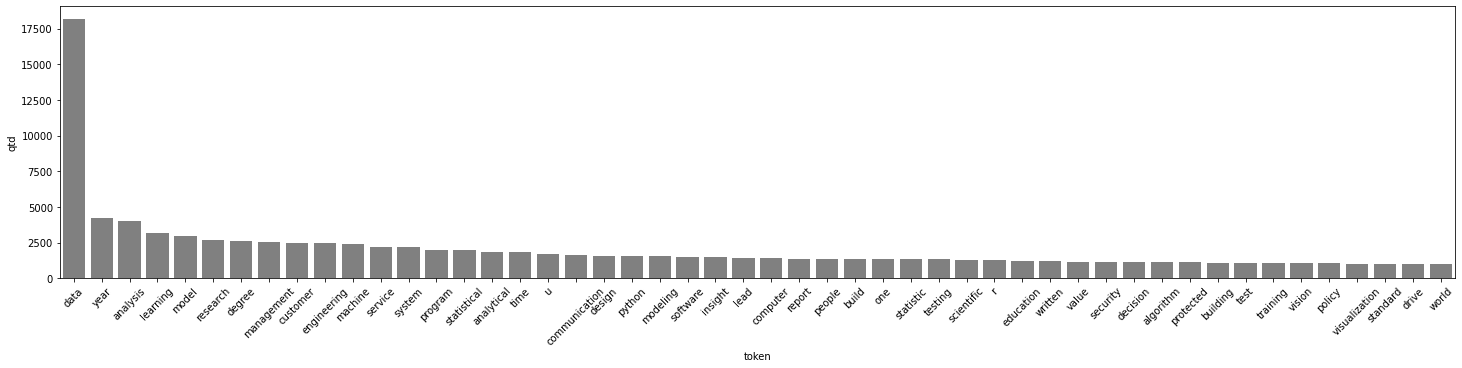

In [17]:
# Plot
plt.figure(figsize=(25, 5))
fig = sns.barplot(data=df_freq.head(50), x='token', y='qtd', color='gray')
fig.tick_params(axis='x', rotation=45)

In [18]:
# Checking in how many jobs a specific term is present.
def jobs_with_token(df, term):
    qt=0
    for i in df['tokens']:
        for j in i:
            # if term is a substring of current token, then True.
            if j.find(term) != -1:
                qt += 1

                # if condition is True, then go to next job description.
                break

    freq = round(qt/df.shape[0], 2)
    return qt, freq

In [19]:
# General terms (expecting high frequency).
list_terms = ['python', 'bachelor', 'sql', 'analysis']
for i in list_terms:
    print(i, jobs_with_token(df_eda, i))

python (1328, 0.57)
bachelor (1089, 0.47)
sql (938, 0.4)
analysis (1545, 0.66)


In [20]:
# Specific terms (expecting moderate-low frequency)
list_terms = ['nlp', 'feature', 'selection', 'pytorch', 'kera', 'tensorflow', 'governance', 'cluster', 'storytelling']
for i in list_terms:
    print(i, jobs_with_token(df_eda, i))

nlp (168, 0.07)
feature (207, 0.09)
selection (177, 0.08)
pytorch (112, 0.05)
kera (80, 0.03)
tensorflow (174, 0.07)
governance (128, 0.05)
cluster (251, 0.11)
storytelling (20, 0.01)


##### data, machine and degree

### Language

In [21]:
# Comparing different languages.
list_lang = ['python', 'sql', 'r', 'java', 'c', 'go', 'julia', 'scala', 'javascript', 'swift', 'matlab', 'sas']
# obs: languages obtained from https://www.datacamp.com/blog/top-programming-languages-for-data-scientists-in-2022

df_lang = df_freq.loc[df_freq['token'].isin(list_lang)]
df_lang['perc'] = (df_lang['qtd'] / df_lang['qtd'].sum() * 100).astype(int)

df_lang

C:\Users\Kenji\AppData\Local\Temp\ipykernel_39876\2258299198.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lang['perc'] = (df_lang['qtd'] / df_lang['qtd'].sum() * 100).astype(int)


,token,qtd,perc
103,python,1540,32
104,r,1262,26
101,sql,964,20
394,java,261,5
609,c,180,3
395,scala,175,3
1393,go,138,2
1768,matlab,113,2
604,julia,51,1
606,javascript,47,0


In [22]:
# Checking the frequency of python, r and sql in job descriptions.
df_eda['python'] = 0
df_eda['r'] = 0
df_eda['sql'] = 0
df_eda['java'] = 0
df_eda['c'] = 0

for index, row in df_eda.iterrows():
    if 'python' in row['tokens']:
        df_eda.loc[index, 'python'] = 1
    
    if 'r' in row['tokens']:
        df_eda.loc[index, 'r'] = 1
    
    if 'sql' in row['tokens']:
        df_eda.loc[index, 'sql'] = 1
    
    if 'java' in row['tokens']:
        df_eda.loc[index, 'java'] = 1
    
    if 'c' in row['tokens']:
        df_eda.loc[index, 'c'] = 1

print(f'''Frequency:
- python: {df_eda['python'].sum() / df_eda.shape[0]}
- r: {df_eda['r'].sum() / df_eda.shape[0]}
- sql: {df_eda['sql'].sum() / df_eda.shape[0]}
- java: {df_eda['java'].sum() / df_eda.shape[0]}
- c: {df_eda['c'].sum() / df_eda.shape[0]}
- Not Python, sql or R: {df_eda.loc[(df_eda['python'] == 0) & (df_eda['r'] == 0) & (df_eda['sql'] == 0)].shape[0] / df_eda.shape[0]}
''')

Frequency:
- python: 0.5380993150684932
- r: 0.4203767123287671
- sql: 0.3240582191780822
- java: 0.09032534246575342
- c: 0.06506849315068493
- Not Python, sql or R: 0.3386130136986301



##### python, R and sql

The majority of program language is definitely `python`, `R` and `sql`, being present in almost in 3 of 4 job postings.

### N-grams

In [23]:
# Creating bigrams and trigrams.
df_eda['bigrams'] = None
df_eda['trigrams'] = None

for index, value in enumerate(df_eda['tokens']):
    list_bigrams = list(nltk.ngrams(value, 2))
    #list_bigrams = [frozenset(i) for i in list_bigrams]
    df_eda.at[index, 'bigrams'] = list_bigrams
    

    list_trigrams = list(nltk.ngrams(value, 3))
    #list_trigrams = [frozenset(i) for i in list_trigrams]
    df_eda.at[index, 'trigrams'] = list_trigrams

df_eda.head(3)

,title,href,description,tokens,python,r,sql,java,c,bigrams,trigrams
0,Recruiting from Scratch está contratando Senio...,https://www.linkedin.com/jobs/view/senior-data...,\nWho is Recruiting from Scratch: Recruiting f...,"[placing, manager, software, hardware, innovat...",1,1,1,0,0,"[(placing, manager), (manager, software), (sof...","[(placing, manager, software), (manager, softw..."
1,Recruiting from Scratch está contratando Senio...,https://www.linkedin.com/jobs/view/senior-data...,\nWho is Recruiting from Scratch: Recruiting f...,"[placing, manager, software, hardware, innovat...",1,0,0,0,0,"[(placing, manager), (manager, software), (sof...","[(placing, manager, software), (manager, softw..."
2,Intuitive Research and Technology Corporation ...,https://www.linkedin.com/jobs/view/entry-level...,\nINTUITIVE® is a nationally recognized Best P...,"[intuitive®, nationally, recognized, place, pr...",1,0,0,0,0,"[(intuitive®, nationally), (nationally, recogn...","[(intuitive®, nationally, recognized), (nation..."


In [24]:
# Unifyng all bigrams and trigrams to a single list.
bigrams = single_list(df_eda['bigrams'])
trigrams = single_list(df_eda['trigrams'])

#### Bigrams

In [25]:
# Organizing the bigram
df_bi = pd.DataFrame({'bigram': bigrams}).value_counts().to_frame().reset_index().rename(columns={0:'qtd'})

list_token1 = []
list_token2 = []
for i in df_bi['bigram']:
    try:
        token1, token2 = i
        list_token1.append(token1)
        list_token2.append(token2)
    except:
        token1 = i
        list_token1.append(token1)
        list_token2.append(token1)
        
df_bi['token1'] = list_token1
df_bi['token2'] = list_token2

In [26]:
df_bi.describe(percentiles=np.array(list(range(1, 10, 1)))/10).T.round(1)

,count,mean,std,min,10%,20%,30%,40%,50%,60%,70%,80%,90%,max
qtd,219042.0,3.0,9.6,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,3.0,5.0,2222.0


In [27]:
# Total number of appearances (a bigram may appear multiple times in a single job)
df_bi.head(20)

,bigram,qtd,token1,token2
0,"(machine, learning)",2222,machine,learning
1,"(data, analysis)",786,data,analysis
2,"(bachelor, degree)",705,bachelor,degree
3,"(data, visualization)",543,data,visualization
4,"(master, degree)",530,master,degree
5,"(data, set)",484,data,set
6,"(python, r)",480,python,r
7,"(data, data)",411,data,data
8,"(data, management)",387,data,management
9,"(deep, learning)",386,deep,learning


In [28]:
# Check ngrams frequency (how many jobs uses the ngram)
def jobs_with_ngram(df, ngram):
    if len(ngram) == 2:
        column = 'bigrams'
    else:
        column='trigrams'

    qt = 0
    for i in df[column]:
        if ngram in i:
            qt += 1
    freq = round(qt/df.shape[0], 2)
    return qt, freq

In [29]:
# General bigram (expecting high frequency).
list_bigrams_general = [('machine', 'learning'), ('data', 'visualization'), ('data', 'analysis')]
for i in list_bigrams_general:
    print(i, jobs_with_ngram(df_eda, i))

('machine', 'learning') (964, 0.41)
('data', 'visualization') (406, 0.17)
('data', 'analysis') (548, 0.23)


In [30]:
# Specific bigram (expecting low-moderate frequency).
list_bigrams_general = [('feature', 'engineering'), ('feature', 'selection'), ('survival', 'analysis')]
for i in list_bigrams_general:
    print(i, jobs_with_ngram(df_eda, i))

('feature', 'engineering') (41, 0.02)
('feature', 'selection') (11, 0.0)
('survival', 'analysis') (11, 0.0)


##### (machine-learning), (data-analysis)

The majority of the sample are unique bigrams (percentile 70), with the most frequent bigram appeared 209 times. This result can be perceived as a sign that we may be in the correct path; since our goal is to retrieve the most relevant bigrams, we reduces our burden in at least 70%.



### Trigram

In [31]:
# Organizing the trigram.
df_tri = pd.DataFrame({'trigram': trigrams}).value_counts().to_frame().reset_index().rename(columns={0:'qtd'})
df_tri.describe(percentiles=np.array(list(range(1, 10, 1)))/10).T.round(1)

,count,mean,std,min,10%,20%,30%,40%,50%,60%,70%,80%,90%,max
qtd,286220.0,2.3,4.9,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,4.0,183.0


In [32]:
# Total number of appearances.
df_tri.head(20)

,trigram,qtd
0,"(machine, learning, model)",183
1,"(data, machine, learning)",167
2,"(management, accel, dfj)",158
3,"(written, verbal, communication)",158
4,"(hardware, innovative, 100)",158
5,"(innovative, 100, management)",158
6,"(100, management, accel)",158
7,"(manager, software, hardware)",158
8,"(software, hardware, innovative)",158
9,"(placing, manager, software)",158


In [33]:
# Filter only trigrams based on data.
list_index = []
for index, value in enumerate(df_tri['trigram']):
    if 'data' in str(value):
        list_index.append(index)

df_tri.loc[list_index].head(10)

,trigram,qtd
1,"(data, machine, learning)",167
12,"(large, data, set)",137
35,"(machine, learning, data)",91
37,"(data, tech, stack)",90
43,"(structured, unstructured, data)",88
47,"(decision, looking, data)",87
49,"(data, growing, digital)",87
55,"(strategy-oriented, data, quantitative)",87
66,"(data, data-driven, insight)",87
70,"(interpret, on-chain, data)",87


In [34]:
# Filter only trigrams based on data.
list_index = []
for index, value in enumerate(df_eda['trigrams']):
    if 'data' in str(value):
        list_index.append(index)

temp = df_eda.loc[list_index, 'trigrams']
data_trigrams = single_list(temp)

df_data_tri = pd.DataFrame({'trigrams': data_trigrams}).value_counts().to_frame().reset_index().rename(columns={0:'qtd'})
df_data_tri.head(20)

,trigrams,qtd
0,"(machine, learning, model)",181
1,"(data, machine, learning)",167
2,"(innovative, 100, management)",158
3,"(manager, software, hardware)",158
4,"(software, hardware, innovative)",158
5,"(placing, manager, software)",158
6,"(management, accel, dfj)",158
7,"(hardware, innovative, 100)",158
8,"(100, management, accel)",158
9,"(written, verbal, communication)",157


In [35]:
# General trigram (expecting high frequency).
list_trigrams_general = [('machine', 'learning', 'model'), ('written', 'verbal', 'communication'), ('large', 'data', 'set'), ('quantitative', 'statistical', 'analysis'), ('statistical', 'analysis', 'regression')]
for i in list_trigrams_general:
    print(i, jobs_with_ngram(df_eda, i))

('machine', 'learning', 'model') (147, 0.06)
('written', 'verbal', 'communication') (145, 0.06)
('large', 'data', 'set') (114, 0.05)
('quantitative', 'statistical', 'analysis') (89, 0.04)
('statistical', 'analysis', 'regression') (101, 0.04)


In [36]:
# Return the raw description based on a specific trigram.
#trigram_find = ('placing', 'manager', 'software')
trigram_find = ('written', 'verbal', 'communication')

list_index = []
for index, value in enumerate(df_eda['trigrams']):
    if trigram_find in value:
        list_index.append(index)

display(df_eda.loc[list_index].sample(5))

display(df_eda.loc[2072, 'description'])


,title,href,description,tokens,python,r,sql,java,c,bigrams,trigrams
558,Corteva Agriscience está contratando Principal...,https://www.linkedin.com/jobs/view/principal-d...,\n 225381W-09DescriptionCorteva Agrisci...,"[225381w-09descriptioncorteva, agriscience™, r...",1,1,0,0,0,"[(225381w-09descriptioncorteva, agriscience™),...","[(225381w-09descriptioncorteva, agriscience™, ..."
1496,MillenniumSoft Inc está contratando Scientist ...,https://www.linkedin.com/jobs/view/scientist-a...,\nPosition : Scientist Location : Research Tr...,"[location, research, triangle, park, nc, durat...",0,1,0,0,0,"[(location, research), (research, triangle), (...","[(location, research, triangle), (research, tr..."
2330,1.000 vagas de Data Scientist Iii em: Estados ...,https://www.linkedin.com/jobs/data-scientist-i...,\nCompany DescriptionWe are a global leader in...,"[descriptionwe, manufacturing, active, pharmac...",0,1,0,0,0,"[(descriptionwe, manufacturing), (manufacturin...","[(descriptionwe, manufacturing, active), (manu..."
267,"AstraZeneca está contratando Director, Commerc...",https://www.linkedin.com/jobs/view/director-co...,\nMake a greater impact on lives through a dig...,"[greater, digitally-enabled, enterprisewe, tow...",1,1,1,0,0,"[(greater, digitally-enabled), (digitally-enab...","[(greater, digitally-enabled, enterprisewe), (..."
604,"BioSpace está contratando Director, Commercial...",https://www.linkedin.com/jobs/view/director-co...,\nGeneral Scope And SummarySage Therapeutics i...,"[general, scope, summarysage, therapeutic, sea...",1,1,1,0,0,"[(general, scope), (scope, summarysage), (summ...","[(general, scope, summarysage), (scope, summar..."


"\nWHO ARE WE?Launch Potato is a digital media company with a portfolio of brands and technologies. As The Discovery and Conversion Company, Launch Potato's mission is to be the most innovative, tech-enabled media company connecting consumers to the world's leading brands.The company is headquartered in vibrant downtown Delray Beach, Florida, with a unique international team across over a dozen countries. Launch Potato's success comes from a diverse, energetic culture and a high-performing, entrepreneurial team.YOUR ROLEWe need someone like you to lead efforts in transforming enterprise data into actionable insights. Reporting to the Associate Director of Analytics, you will develop a deep understanding of Launch Potato's data to support yield, user acquisition, product, remarketing, and account managers.You will become the subject matter expert in at least one vertical, including, but not limited to, insurance, credit cards, and/or SEO. In addition, you will own reporting standardizat

##### (machine, learning, model)

In a superficial view, trigrams were not insightful. Although the most frequent combinations were relevant (e.g. `machine-learning-model`), there were trigrams with high frequency because of similar job posting (e.g. `placing-manager-software` from a single company called Scratch).

## Conclusion

The most relevant keywords are:

- machine learning
- data analysis
- python
- r
- bachelor's and/or master's degree
- data visualization
- deep learning
- statistical analysis
- data mining
- verbal and written communication skills

##### Insights

- Specific keywords (e.g. feature selection or feature engineering) are significantly less frequent than general keywords (e.g. machine learning, deep learning). This fact does not necessarily means that specific keywords are not relevant, just that these keywords may be more relevant in specific job positions.

- Education matters a lot! Oriented bachelor's or master's degree are frequently found in job descriptions.
